In [156]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor

sns.set(style="whitegrid", font_scale=1.2)

In [157]:
# Load the data
train_df = pd.read_csv('dataset/train.csv').drop('id', axis=1)
test_df = pd.read_csv('dataset/test.csv')

test_id = test_df['id']
test_df = test_df.drop('id', axis=1)

Basic EDA:
1. Check the first 5 rows, statistics, data types, null values, and unique values of each attributes.
2. 

In [158]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 22.9+ MB


In [159]:
train_df.head(5)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [160]:
train_df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [161]:
train_df.isnull().sum()

Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [162]:
train_df.nunique()

Brand                        5
Material                     4
Size                         3
Compartments                10
Laptop Compartment           2
Waterproof                   2
Style                        3
Color                        6
Weight Capacity (kg)    181596
Price                    48212
dtype: int64

In [163]:
categorical_columns = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
numerical_columns = ['Weight Capacity (kg)']
target_column = ['Price']

In [164]:
# Handling Missing Values
def handle_missing_values(df):
    # Fill missing values for categorical columns with 'None'
    # for col in categorical_columns:
    #     df[col].fillna('None' , inplace=True)

    # Fill missing values for categorical columns with the mode
    for col in categorical_columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    # Fill missing values for numerical columns with the mean
    for col in numerical_columns:
        df[col].fillna(df[col].mean(), inplace=True)

    return df

In [165]:
# Convert categorical columns to category type
def convert_categorical_columns(df):
    for col in categorical_columns:
        try:
            df[col] = df[col].astype('category')
        except KeyError as e:
            print(f"Column {col} not found in one of the datasets: {e}")
        except Exception as e:
            print(f"Error converting {col} to category: {e}")
    return df

In [166]:
train_df_handled = handle_missing_values(train_df.copy())
test_df_handled = handle_missing_values(test_df.copy())

train_df_handled = convert_categorical_columns(train_df_handled)
test_df_handled = convert_categorical_columns(test_df_handled)

/var/folders/s0/vcj8pczn5j96hnr07_pqbv6r0000gn/T/ipykernel_58641/2339758133.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/var/folders/s0/vcj8pczn5j96hnr07_pqbv6r0000gn/T/ipykernel_58641/2339758133.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

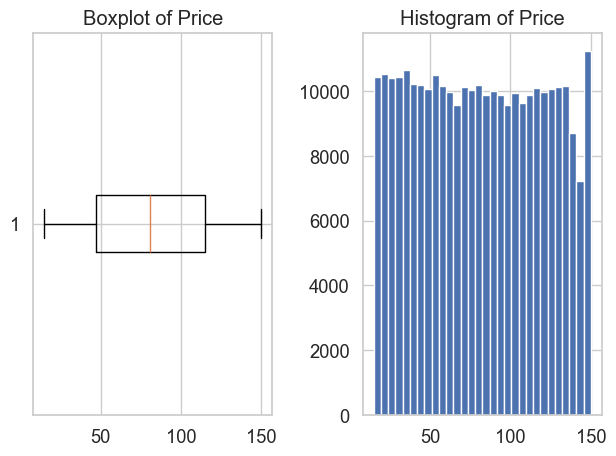

In [167]:
# Target distribution
plt.subplot(1, 2, 1)

plt.boxplot(train_df_handled['Price'], vert=False)

plt.title('Boxplot of Price')
# plt.show()

plt.subplot(1, 2, 2)
plt.hist(train_df_handled['Price'], bins=30)
plt.title('Histogram of Price')

plt.tight_layout()
plt.show()



In [168]:
train_df_handled['Price'].describe()

count    300000.000000
mean         81.411107
std          39.039340
min          15.000000
25%          47.384620
50%          80.956120
75%         115.018160
max         150.000000
Name: Price, dtype: float64

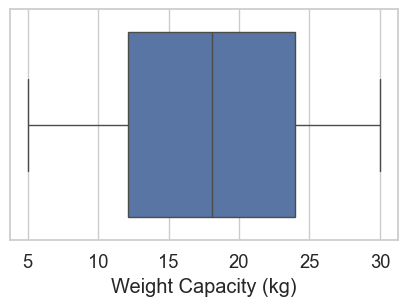

In [169]:
# Find the outliers in the numerical columns

for column in numerical_columns:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=train_df_handled[column])
    plt.show()

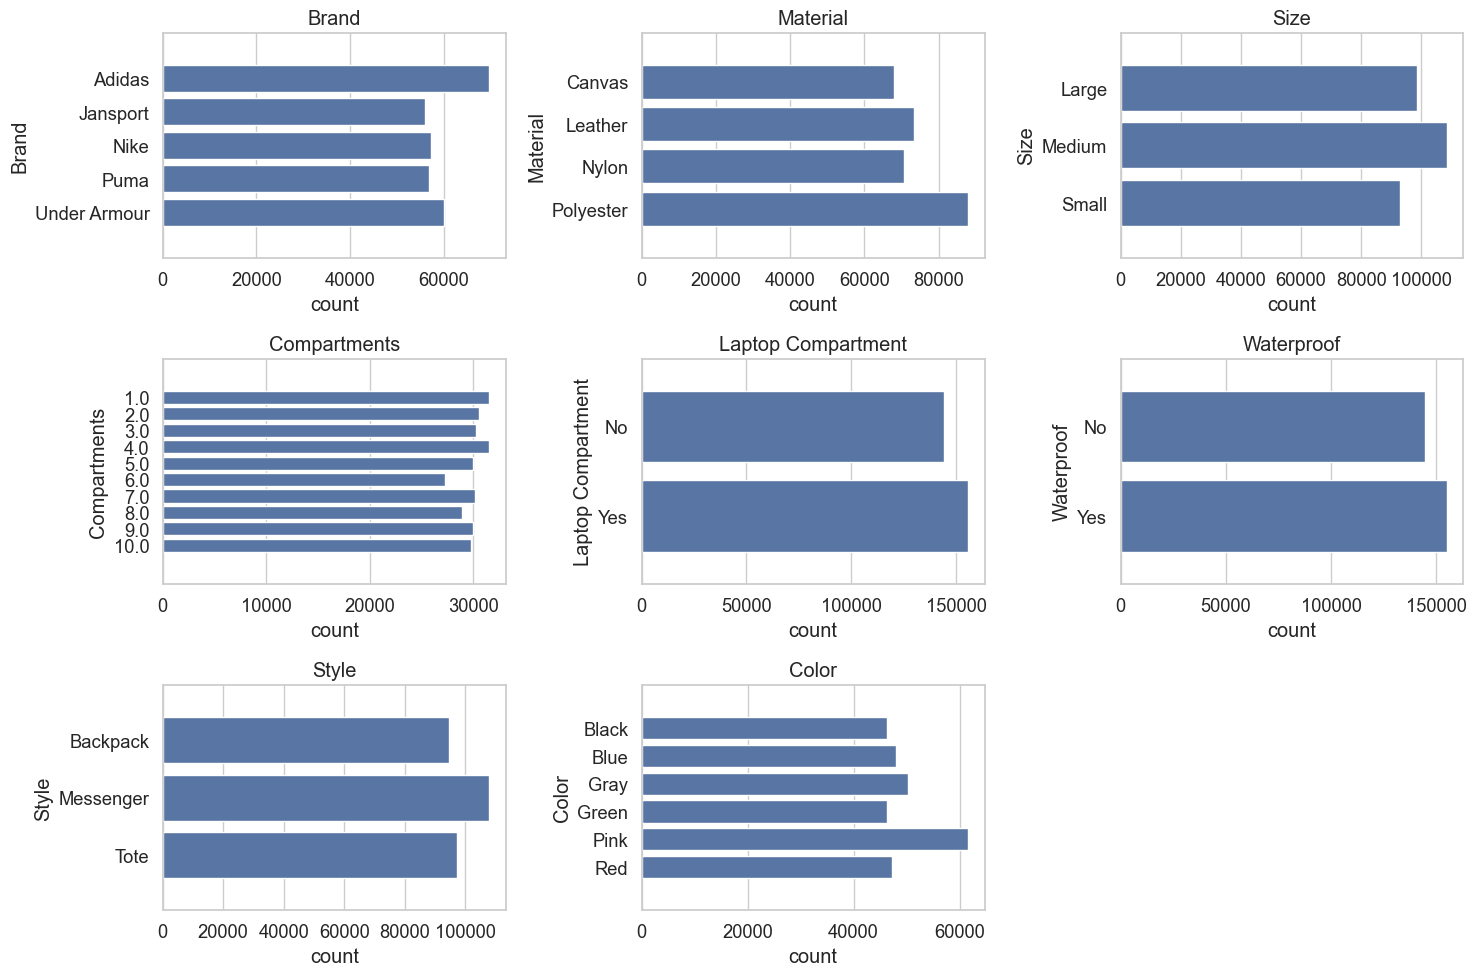

In [170]:
# Categorical columns distribution
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_columns):
    plt.subplot(3,3,i+1)
    ax = sns.countplot(train_df_handled[column])
    ax.margins(y=0.2)

    plt.title(column)

plt.tight_layout()
plt.show()

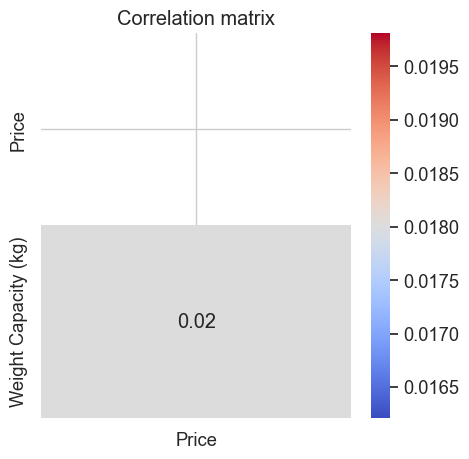

In [171]:
# Correlation matrix
corr_matrix = train_df_handled[target_column + numerical_columns].corr()[target_column]

plt.figure(figsize=(5, 5))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask=mask)
plt.title('Correlation matrix')

plt.show()

In [172]:
# Feature Engineering

# Mapping ordinal categorical variables to numerical values
def map_ordinal_columns(df):
    df['Size'] = df['Size'].map({'Small': 1, 'Medium': 2, 'Large': 3}).astype('Int64')
    df['Compartments'] = df['Compartments'].astype('Int64')
    df['Laptop Compartment'] = df['Laptop Compartment'].map({'No': 0, 'Yes': 1}).astype('Int64')
    df['Waterproof'] = df['Waterproof'].map({'No': 0, 'Yes': 1}).astype('Int64')

    return df

train_df_handled = map_ordinal_columns(train_df_handled)
test_df_handled = map_ordinal_columns(test_df_handled)

In [173]:
# One-hot encoding for nominal categorical variable
nominal_columns = ['Brand', 'Material', 'Style', 'Color']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

oh_encoded = ohe.fit_transform(train_df_handled[nominal_columns])

ohdf = pd.DataFrame(oh_encoded, columns=ohe.get_feature_names_out(nominal_columns))
train_df_handled = pd.concat([train_df_handled.drop(nominal_columns, axis=1), ohdf], axis=1)

oh_encoded_test = ohe.transform(test_df_handled[nominal_columns])

ohdf = pd.DataFrame(oh_encoded_test, columns=ohe.get_feature_names_out(nominal_columns))
test_df_handled = pd.concat([test_df_handled.drop(nominal_columns, axis=1), ohdf], axis=1)





In [176]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

# train_df_handled.isnull().sum()
pca_features = pca.fit_transform(train_df_handled)
pca_features_test = pca.transform(test_df_handled)

pca_df = pd.DataFrame(
    pca_features, 
    columns=[f'PCA_{i+1}' for i in range(pca_features.shape[1])]
)
pca_df_test = pd.DataFrame(
    pca_features_test, 
    columns=[f'PCA_{i+1}' for i in range(pca_features_test.shape[1])]
)

train_df_final = pd.concat([
    train_df_handled.drop(nominal_columns, axis=1),
    pca_df
], axis=1)

test_df_final = pd.concat([
    test_df_handled.drop(nominal_columns, axis=1),
    pca_df_test
], axis=1)

print("原始One-Hot编码特征数:", oh_encoded.shape[1])
print("PCA降维后特征数:", pca_features.shape[1])
print("解释方差比:", sum(pca.explained_variance_ratio_))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Price


In [121]:
test_df_handled

,Size,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,...,Style_Messenger,Style_Tote,Style_nan,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_nan
0,1,2,0,0,20.671147,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,7,0,1,13.564105,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,9,0,1,11.809799,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,1,1,0,18.477036,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3,2,1,1,9.907953,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3,2,1,0,7.383498,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
199996,1,9,0,1,6.058394,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199997,1,9,0,1,26.890163,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
199998,3,10,1,0,25.769153,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [122]:
train_df_handled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Size                  293405 non-null  Int64  
 1   Compartments          300000 non-null  Int64  
 2   Laptop Compartment    292556 non-null  Int64  
 3   Waterproof            292950 non-null  Int64  
 4   Weight Capacity (kg)  300000 non-null  float64
 5   Price                 300000 non-null  float64
 6   Brand_Adidas          300000 non-null  float64
 7   Brand_Jansport        300000 non-null  float64
 8   Brand_Nike            300000 non-null  float64
 9   Brand_Puma            300000 non-null  float64
 10  Brand_Under Armour    300000 non-null  float64
 11  Brand_nan             300000 non-null  float64
 12  Material_Canvas       300000 non-null  float64
 13  Material_Leather      300000 non-null  float64
 14  Material_Nylon        300000 non-null  float64
 15  

In [123]:
# Train-test split
X = train_df_handled.drop(columns=target_column)
y = train_df_handled[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
def random_search(X_train, y_train):
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    
    params = {
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.25, 0.1],
        'max_depth': [1, 3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.4, 0.6, 0.8],
        'colsample_bytree': [0.5, 0.8, 0.9],
        'reg_lambda': [0, 1, 5, 10],
        'min_split_loss': [0, 0.1, 0.5, 1, 3, 5, 10],
        'reg_alpha': [0, 0.1, 1]
    }
    
    random_search = RandomizedSearchCV(xgb, params, 
                                     cv=5, 
                                     scoring='neg_mean_squared_error',
                                     random_state=42, 
                                     verbose=2, 
                                     n_jobs=-1)
    
    random_search.fit(X_train, y_train)
    print("Best parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)

    return random_search.best_params_, random_search.best_score_

In [125]:
# random_search(X_train, y_train)

In [126]:
best_params = {
    'subsample': 0.4,
  'reg_lambda': 0,
  'reg_alpha': 0,
  'n_estimators': 1000,
  'min_split_loss': 0,
  'min_child_weight': 5,
  'max_depth': 1,
  'learning_rate': 0.1,
  'colsample_bytree': 0.9
}

xgb = XGBRegressor(objective='reg:squarederror', early_stopping_rounds=50, eval_metric='rmse',random_state=42, **best_params)
xgb.fit(X_train, y_train,eval_set=[(X_test, y_test)])
print(f"Best XGBoost iteration using RMSE: {xgb.best_iteration} \n")

# params2 = best_params.copy()
# params2['max_depth'] = best_params['max_depth'] + 1

# params3 = best_params.copy()
# params3['learning_rate'] = best_params['learning_rate'] * 0.8

# model1 = XGBRegressor(**best_params)
# model2 = XGBRegressor(**params2)
# model3 = XGBRegressor(**params3)

# ensemble = VotingRegressor([
#     ('m1', model1),
#     ('m2', model2),
#     ('m3', model3)
# ])

# ensemble.fit(X_train, y_train)


[0]	validation_0-rmse:38.94247
[1]	validation_0-rmse:38.94030
[2]	validation_0-rmse:38.93926
[3]	validation_0-rmse:38.93819
[4]	validation_0-rmse:38.93756
[5]	validation_0-rmse:38.93657
[6]	validation_0-rmse:38.93624
[7]	validation_0-rmse:38.93476
[8]	validation_0-rmse:38.93385
[9]	validation_0-rmse:38.93337
[10]	validation_0-rmse:38.93272
[11]	validation_0-rmse:38.93208
[12]	validation_0-rmse:38.93099
[13]	validation_0-rmse:38.93057
[14]	validation_0-rmse:38.92986
[15]	validation_0-rmse:38.92939
[16]	validation_0-rmse:38.92883
[17]	validation_0-rmse:38.92834
[18]	validation_0-rmse:38.92776
[19]	validation_0-rmse:38.92711
[20]	validation_0-rmse:38.92660
[21]	validation_0-rmse:38.92590
[22]	validation_0-rmse:38.92563
[23]	validation_0-rmse:38.92508
[24]	validation_0-rmse:38.92459
[25]	validation_0-rmse:38.92423
[26]	validation_0-rmse:38.92390
[27]	validation_0-rmse:38.92355
[28]	validation_0-rmse:38.92321
[29]	validation_0-rmse:38.92263
[30]	validation_0-rmse:38.92236
[31]	validation_0-

In [127]:
# Predicting on the test set
y_pred = xgb.predict(X_test, iteration_range=(0, xgb.best_iteration))
# y_pred = ensemble.predict(X_test)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE: {rmse(y_test, y_pred)}")

RMSE: 38.9054577605082


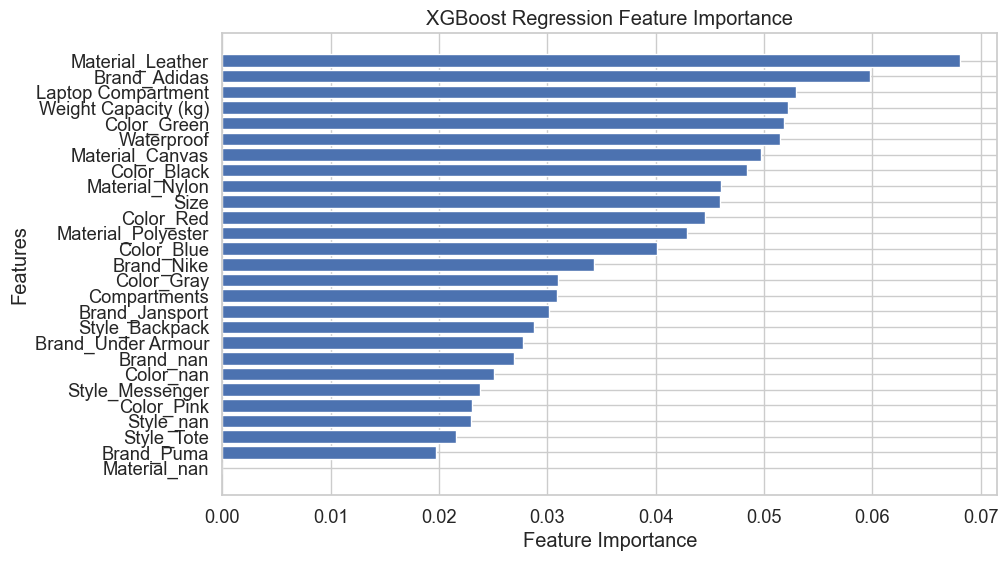

In [128]:
# Feature Importance
importance_xgb = xgb.feature_importances_
sorted_idx = np.argsort(importance_xgb)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh([features[i] for i in sorted_idx], importance_xgb[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Regression Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

In [ ]:
# Predicting on the test set
test_pred = xgb.predict(test_df_handled, iteration_range=(0, xgb.best_iteration))
# test_pred = ensemble.predict(test_df_handled)
test_pred


array([82.22352 , 83.01962 , 81.64909 , ..., 82.83387 , 81.99716 ,
       81.473946], dtype=float32)

In [ ]:
test_df_handled

,Size,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Brand_Adidas,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,...,Style_Messenger,Style_Tote,Style_nan,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Color_nan
0,1,2,0,0,20.671147,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,7,0,1,13.564105,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,9,0,1,11.809799,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,1,1,0,18.477036,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3,2,1,1,9.907953,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3,2,1,0,7.383498,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
199996,1,9,0,1,6.058394,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199997,1,9,0,1,26.890163,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
199998,3,10,1,0,25.769153,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [132]:
submission = pd.DataFrame({'id': test_id, 'Price': test_pred})
submission.to_csv('submission.csv', index=False)
display(submission)

,id,Price
0,300000,82.223518
1,300001,83.019623
2,300002,81.649094
3,300003,82.373802
4,300004,79.066826
...,...,...
199995,499995,79.406960
199996,499996,78.777679
199997,499997,82.833870
199998,499998,81.997162
